# MODEL 1: DEEPLABV3 WITH PRETRAINED WEIGHTS (with Finetunning)

### Part 0: Setting up the environment

In [1]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import DataLoader, random_split
from torchvision.io import read_image
import torch.nn.functional as F
import numpy as np
import time, os, json
from tqdm import tqdm
import glob
import kagglehub
import matplotlib.pyplot as plt

c:\Users\TriTran\Documents\TAMU\SPRING_25\CSCE_753_CV\Project_main\envs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Part 1: Configurating datasets and functions

In [2]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download and extract Kaggle dataset
base_path = kagglehub.dataset_download("triminhtran/csce670-segmentation-dataset")
image_dir = os.path.join(base_path, "JPEGImages")
mask_dir = os.path.join(base_path, "SegmentationClass")

# Dataset Class
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.png')))
        self.transform = transform
        self.mask_transform = T.Resize((435,640), interpolation=T.InterpolationMode.NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx]).float() / 255.0
        mask = read_image(self.mask_paths[idx])[0]

        # Normalize mask labels explicitly to [0, 1]
        mask = (mask > 0).long()

        if self.transform:
            img = self.transform(img)
        
        mask = self.mask_transform(mask.unsqueeze(0)).squeeze(0)
        return img, mask

# Metrics Calculation
def calculate_metrics(pred, target):
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    intersection = np.logical_and(target, pred).sum()
    union = np.logical_or(target, pred).sum()
    pred_sum = pred.sum()
    target_sum = target.sum()

    iou = intersection / union if union != 0 else np.nan
    pixel_acc = (pred == target).mean()
    precision = intersection / pred_sum if pred_sum != 0 else np.nan
    recall = intersection / target_sum if target_sum != 0 else np.nan

    return iou, pixel_acc, precision, recall


### Part 2: Loading dataset and model

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())

True
0
NVIDIA GeForce RTX 4080 SUPER


In [4]:
# Load Data
dataset = SegmentationDataset(
    image_dir, mask_dir,
    transform=T.Resize((435,640))
)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8)
test_loader = DataLoader(test_data, batch_size=1)

# Load Model
# model = deeplabv3_resnet50(pretrained=True).to(device)

# Specify number of classes
num_classes = 2  # "reef" and "background"

# Load pretrained DeepLabV3 and modify final layer to match number of classes
model = deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = torch.nn.Conv2d(256, num_classes, kernel_size=1)
model = model.to(device)

c:\Users\TriTran\Documents\TAMU\SPRING_25\CSCE_753_CV\Project_main\envs\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TriTran\Documents\TAMU\SPRING_25\CSCE_753_CV\Project_main\envs\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Part 3: Training

In [5]:
# Fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 100
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_acc = 0, 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(1)
        total_acc += (preds == masks).float().mean().item()

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks.long())
            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_acc += (preds == masks).float().mean().item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Acc: {avg_val_acc:.4f}")


Epoch 1/100: 100%|██████████| 47/47 [00:18<00:00,  2.48it/s]


Epoch 1 - Train Loss: 0.3891, Val Loss: 0.2610, Train Acc: 0.9440, Val Acc: 0.9876


Epoch 2/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 2 - Train Loss: 0.1746, Val Loss: 0.1481, Train Acc: 0.9920, Val Acc: 0.9903


Epoch 3/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 3 - Train Loss: 0.1179, Val Loss: 0.1021, Train Acc: 0.9939, Val Acc: 0.9924


Epoch 4/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 4 - Train Loss: 0.0868, Val Loss: 0.0768, Train Acc: 0.9951, Val Acc: 0.9932


Epoch 5/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 5 - Train Loss: 0.0679, Val Loss: 0.0681, Train Acc: 0.9957, Val Acc: 0.9924


Epoch 6/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 6 - Train Loss: 0.0549, Val Loss: 0.0573, Train Acc: 0.9960, Val Acc: 0.9929


Epoch 7/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 7 - Train Loss: 0.0443, Val Loss: 0.0484, Train Acc: 0.9967, Val Acc: 0.9939


Epoch 8/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 8 - Train Loss: 0.0368, Val Loss: 0.0407, Train Acc: 0.9971, Val Acc: 0.9941


Epoch 9/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 9 - Train Loss: 0.0323, Val Loss: 0.0383, Train Acc: 0.9971, Val Acc: 0.9940


Epoch 10/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 10 - Train Loss: 0.0275, Val Loss: 0.0357, Train Acc: 0.9973, Val Acc: 0.9937


Epoch 11/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 11 - Train Loss: 0.0241, Val Loss: 0.0321, Train Acc: 0.9975, Val Acc: 0.9941


Epoch 12/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 12 - Train Loss: 0.0214, Val Loss: 0.0309, Train Acc: 0.9977, Val Acc: 0.9941


Epoch 13/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 13 - Train Loss: 0.0191, Val Loss: 0.0292, Train Acc: 0.9978, Val Acc: 0.9941


Epoch 14/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 14 - Train Loss: 0.0170, Val Loss: 0.0279, Train Acc: 0.9980, Val Acc: 0.9943


Epoch 15/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 15 - Train Loss: 0.0154, Val Loss: 0.0270, Train Acc: 0.9981, Val Acc: 0.9942


Epoch 16/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 16 - Train Loss: 0.0139, Val Loss: 0.0251, Train Acc: 0.9982, Val Acc: 0.9945


Epoch 17/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 17 - Train Loss: 0.0128, Val Loss: 0.0263, Train Acc: 0.9983, Val Acc: 0.9944


Epoch 18/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 18 - Train Loss: 0.0117, Val Loss: 0.0241, Train Acc: 0.9984, Val Acc: 0.9944


Epoch 19/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 19 - Train Loss: 0.0110, Val Loss: 0.0248, Train Acc: 0.9984, Val Acc: 0.9941


Epoch 20/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 20 - Train Loss: 0.0101, Val Loss: 0.0236, Train Acc: 0.9985, Val Acc: 0.9945


Epoch 21/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 21 - Train Loss: 0.0095, Val Loss: 0.0231, Train Acc: 0.9985, Val Acc: 0.9944


Epoch 22/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 22 - Train Loss: 0.0090, Val Loss: 0.0226, Train Acc: 0.9986, Val Acc: 0.9944


Epoch 23/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 23 - Train Loss: 0.0084, Val Loss: 0.0223, Train Acc: 0.9986, Val Acc: 0.9945


Epoch 24/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 24 - Train Loss: 0.0080, Val Loss: 0.0226, Train Acc: 0.9986, Val Acc: 0.9944


Epoch 25/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 25 - Train Loss: 0.0075, Val Loss: 0.0219, Train Acc: 0.9987, Val Acc: 0.9945


Epoch 26/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 26 - Train Loss: 0.0071, Val Loss: 0.0217, Train Acc: 0.9987, Val Acc: 0.9945


Epoch 27/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 27 - Train Loss: 0.0068, Val Loss: 0.0220, Train Acc: 0.9987, Val Acc: 0.9944


Epoch 28/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 28 - Train Loss: 0.0066, Val Loss: 0.0234, Train Acc: 0.9987, Val Acc: 0.9941


Epoch 29/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 29 - Train Loss: 0.0065, Val Loss: 0.0209, Train Acc: 0.9987, Val Acc: 0.9946


Epoch 30/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 30 - Train Loss: 0.0060, Val Loss: 0.0205, Train Acc: 0.9988, Val Acc: 0.9947


Epoch 31/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 31 - Train Loss: 0.0057, Val Loss: 0.0215, Train Acc: 0.9988, Val Acc: 0.9946


Epoch 32/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 32 - Train Loss: 0.0055, Val Loss: 0.0211, Train Acc: 0.9988, Val Acc: 0.9945


Epoch 33/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 33 - Train Loss: 0.0053, Val Loss: 0.0219, Train Acc: 0.9988, Val Acc: 0.9946


Epoch 34/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 34 - Train Loss: 0.0050, Val Loss: 0.0221, Train Acc: 0.9989, Val Acc: 0.9945


Epoch 35/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 35 - Train Loss: 0.0048, Val Loss: 0.0213, Train Acc: 0.9989, Val Acc: 0.9946


Epoch 36/100: 100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Epoch 36 - Train Loss: 0.0047, Val Loss: 0.0208, Train Acc: 0.9989, Val Acc: 0.9947


Epoch 37/100: 100%|██████████| 47/47 [00:17<00:00,  2.62it/s]


Epoch 37 - Train Loss: 0.0045, Val Loss: 0.0206, Train Acc: 0.9990, Val Acc: 0.9947


Epoch 38/100: 100%|██████████| 47/47 [00:18<00:00,  2.60it/s]


Epoch 38 - Train Loss: 0.0043, Val Loss: 0.0202, Train Acc: 0.9990, Val Acc: 0.9947


Epoch 39/100: 100%|██████████| 47/47 [00:18<00:00,  2.61it/s]


Epoch 39 - Train Loss: 0.0043, Val Loss: 0.0205, Train Acc: 0.9990, Val Acc: 0.9947


Epoch 40/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 40 - Train Loss: 0.0041, Val Loss: 0.0201, Train Acc: 0.9990, Val Acc: 0.9948


Epoch 41/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 41 - Train Loss: 0.0040, Val Loss: 0.0206, Train Acc: 0.9990, Val Acc: 0.9948


Epoch 42/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 42 - Train Loss: 0.0039, Val Loss: 0.0204, Train Acc: 0.9990, Val Acc: 0.9947


Epoch 43/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 43 - Train Loss: 0.0038, Val Loss: 0.0212, Train Acc: 0.9991, Val Acc: 0.9947


Epoch 44/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 44 - Train Loss: 0.0037, Val Loss: 0.0202, Train Acc: 0.9991, Val Acc: 0.9949


Epoch 45/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 45 - Train Loss: 0.0036, Val Loss: 0.0202, Train Acc: 0.9991, Val Acc: 0.9948


Epoch 46/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 46 - Train Loss: 0.0035, Val Loss: 0.0202, Train Acc: 0.9991, Val Acc: 0.9948


Epoch 47/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 47 - Train Loss: 0.0034, Val Loss: 0.0213, Train Acc: 0.9991, Val Acc: 0.9946


Epoch 48/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 48 - Train Loss: 0.0033, Val Loss: 0.0212, Train Acc: 0.9991, Val Acc: 0.9947


Epoch 49/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 49 - Train Loss: 0.0032, Val Loss: 0.0213, Train Acc: 0.9992, Val Acc: 0.9947


Epoch 50/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 50 - Train Loss: 0.0031, Val Loss: 0.0205, Train Acc: 0.9992, Val Acc: 0.9948


Epoch 51/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 51 - Train Loss: 0.0031, Val Loss: 0.0225, Train Acc: 0.9991, Val Acc: 0.9946


Epoch 52/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 52 - Train Loss: 0.0031, Val Loss: 0.0221, Train Acc: 0.9991, Val Acc: 0.9947


Epoch 53/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 53 - Train Loss: 0.0030, Val Loss: 0.0213, Train Acc: 0.9991, Val Acc: 0.9948


Epoch 54/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 54 - Train Loss: 0.0029, Val Loss: 0.0208, Train Acc: 0.9992, Val Acc: 0.9948


Epoch 55/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 55 - Train Loss: 0.0029, Val Loss: 0.0217, Train Acc: 0.9991, Val Acc: 0.9947


Epoch 56/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 56 - Train Loss: 0.0029, Val Loss: 0.0225, Train Acc: 0.9992, Val Acc: 0.9947


Epoch 57/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 57 - Train Loss: 0.0028, Val Loss: 0.0209, Train Acc: 0.9992, Val Acc: 0.9949


Epoch 58/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 58 - Train Loss: 0.0027, Val Loss: 0.0213, Train Acc: 0.9992, Val Acc: 0.9948


Epoch 59/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 59 - Train Loss: 0.0026, Val Loss: 0.0217, Train Acc: 0.9992, Val Acc: 0.9948


Epoch 60/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 60 - Train Loss: 0.0026, Val Loss: 0.0219, Train Acc: 0.9992, Val Acc: 0.9949


Epoch 61/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 61 - Train Loss: 0.0025, Val Loss: 0.0217, Train Acc: 0.9993, Val Acc: 0.9948


Epoch 62/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 62 - Train Loss: 0.0025, Val Loss: 0.0221, Train Acc: 0.9993, Val Acc: 0.9949


Epoch 63/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 63 - Train Loss: 0.0024, Val Loss: 0.0236, Train Acc: 0.9993, Val Acc: 0.9946


Epoch 64/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 64 - Train Loss: 0.0024, Val Loss: 0.0220, Train Acc: 0.9993, Val Acc: 0.9949


Epoch 65/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 65 - Train Loss: 0.0024, Val Loss: 0.0215, Train Acc: 0.9993, Val Acc: 0.9949


Epoch 66/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 66 - Train Loss: 0.0024, Val Loss: 0.0229, Train Acc: 0.9992, Val Acc: 0.9948


Epoch 67/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 67 - Train Loss: 0.0024, Val Loss: 0.0229, Train Acc: 0.9992, Val Acc: 0.9949


Epoch 68/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 68 - Train Loss: 0.0023, Val Loss: 0.0216, Train Acc: 0.9993, Val Acc: 0.9950


Epoch 69/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 69 - Train Loss: 0.0022, Val Loss: 0.0222, Train Acc: 0.9993, Val Acc: 0.9950


Epoch 70/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 70 - Train Loss: 0.0022, Val Loss: 0.0231, Train Acc: 0.9993, Val Acc: 0.9949


Epoch 71/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 71 - Train Loss: 0.0022, Val Loss: 0.0221, Train Acc: 0.9993, Val Acc: 0.9949


Epoch 72/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 72 - Train Loss: 0.0022, Val Loss: 0.0221, Train Acc: 0.9993, Val Acc: 0.9949


Epoch 73/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 73 - Train Loss: 0.0022, Val Loss: 0.0228, Train Acc: 0.9992, Val Acc: 0.9950


Epoch 74/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 74 - Train Loss: 0.0022, Val Loss: 0.0231, Train Acc: 0.9992, Val Acc: 0.9948


Epoch 75/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 75 - Train Loss: 0.0025, Val Loss: 0.0267, Train Acc: 0.9992, Val Acc: 0.9943


Epoch 76/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 76 - Train Loss: 0.0163, Val Loss: 0.0451, Train Acc: 0.9945, Val Acc: 0.9847


Epoch 77/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 77 - Train Loss: 0.0149, Val Loss: 0.0173, Train Acc: 0.9947, Val Acc: 0.9937


Epoch 78/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 78 - Train Loss: 0.0088, Val Loss: 0.0192, Train Acc: 0.9967, Val Acc: 0.9935


Epoch 79/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 79 - Train Loss: 0.0061, Val Loss: 0.0194, Train Acc: 0.9978, Val Acc: 0.9943


Epoch 80/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 80 - Train Loss: 0.0050, Val Loss: 0.0175, Train Acc: 0.9982, Val Acc: 0.9947


Epoch 81/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 81 - Train Loss: 0.0064, Val Loss: 0.0245, Train Acc: 0.9978, Val Acc: 0.9934


Epoch 82/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 82 - Train Loss: 0.0056, Val Loss: 0.0201, Train Acc: 0.9980, Val Acc: 0.9943


Epoch 83/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 83 - Train Loss: 0.0042, Val Loss: 0.0198, Train Acc: 0.9985, Val Acc: 0.9946


Epoch 84/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 84 - Train Loss: 0.0035, Val Loss: 0.0197, Train Acc: 0.9987, Val Acc: 0.9946


Epoch 85/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 85 - Train Loss: 0.0032, Val Loss: 0.0213, Train Acc: 0.9988, Val Acc: 0.9946


Epoch 86/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 86 - Train Loss: 0.0029, Val Loss: 0.0212, Train Acc: 0.9990, Val Acc: 0.9948


Epoch 87/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 87 - Train Loss: 0.0027, Val Loss: 0.0217, Train Acc: 0.9990, Val Acc: 0.9947


Epoch 88/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 88 - Train Loss: 0.0026, Val Loss: 0.0214, Train Acc: 0.9991, Val Acc: 0.9948


Epoch 89/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 89 - Train Loss: 0.0024, Val Loss: 0.0222, Train Acc: 0.9991, Val Acc: 0.9948


Epoch 90/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 90 - Train Loss: 0.0023, Val Loss: 0.0218, Train Acc: 0.9992, Val Acc: 0.9948


Epoch 91/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 91 - Train Loss: 0.0022, Val Loss: 0.0224, Train Acc: 0.9992, Val Acc: 0.9948


Epoch 92/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 92 - Train Loss: 0.0022, Val Loss: 0.0220, Train Acc: 0.9992, Val Acc: 0.9949


Epoch 93/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 93 - Train Loss: 0.0021, Val Loss: 0.0231, Train Acc: 0.9992, Val Acc: 0.9947


Epoch 94/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 94 - Train Loss: 0.0021, Val Loss: 0.0228, Train Acc: 0.9993, Val Acc: 0.9949


Epoch 95/100: 100%|██████████| 47/47 [00:17<00:00,  2.67it/s]


Epoch 95 - Train Loss: 0.0021, Val Loss: 0.0233, Train Acc: 0.9992, Val Acc: 0.9948


Epoch 96/100: 100%|██████████| 47/47 [00:18<00:00,  2.56it/s]


Epoch 96 - Train Loss: 0.0020, Val Loss: 0.0236, Train Acc: 0.9992, Val Acc: 0.9948


Epoch 97/100: 100%|██████████| 47/47 [00:18<00:00,  2.60it/s]


Epoch 97 - Train Loss: 0.0020, Val Loss: 0.0233, Train Acc: 0.9992, Val Acc: 0.9949


Epoch 98/100: 100%|██████████| 47/47 [00:18<00:00,  2.60it/s]


Epoch 98 - Train Loss: 0.0020, Val Loss: 0.0233, Train Acc: 0.9993, Val Acc: 0.9948


Epoch 99/100: 100%|██████████| 47/47 [00:18<00:00,  2.59it/s]


Epoch 99 - Train Loss: 0.0019, Val Loss: 0.0232, Train Acc: 0.9993, Val Acc: 0.9949


Epoch 100/100: 100%|██████████| 47/47 [00:18<00:00,  2.57it/s]


Epoch 100 - Train Loss: 0.0019, Val Loss: 0.0230, Train Acc: 0.9993, Val Acc: 0.9949


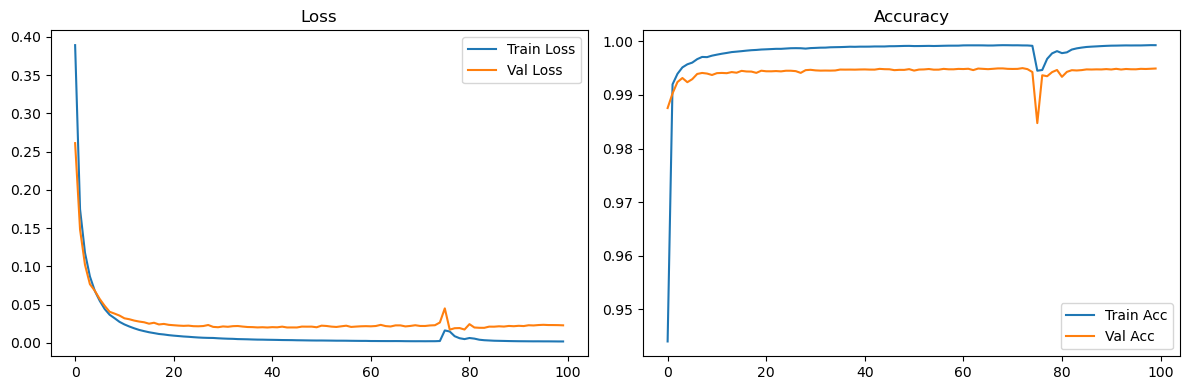

In [6]:
# Plot training metrics
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(val_losses, label="Val Loss")
axs[0].set_title("Loss")
axs[0].legend()

axs[1].plot(train_accs, label="Train Acc")
axs[1].plot(val_accs, label="Val Acc")
axs[1].set_title("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

### Part 4: Evaluating

In [7]:
# Save Model
model.eval()
torch.save(model.state_dict(), "deeplabv3_finetuned.pth")
storage_size = os.path.getsize("deeplabv3_finetuned.pth") / (1024 ** 2)

# Test evaluation and metrics
metrics_summary = {
    "param_count": sum(p.numel() for p in model.parameters() if p.requires_grad),
    "storage_size_MB": storage_size,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs,
    "test_loss": [],
    "test_accuracy": [],
    "iou": [],
    "pixel_accuracy": [],
    "precision": [],
    "recall": [],
    "gpu_memory_MB": [],
    "inference_time_per_image": []
}

# Test evaluation
with torch.no_grad():
    for images, masks in tqdm(test_loader):
        images, masks = images.to(device), masks.to(device)
        
        # Reset GPU memory stats
        torch.cuda.reset_peak_memory_stats(device)

        # Start inference timer
        start_time = time.time()

        outputs = model(images)['out']

        # Measure inference time
        inference_time = time.time() - start_time

        # Measure GPU memory usage in MB
        gpu_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

        # Store inference metrics
        metrics_summary["inference_time_per_image"].append(inference_time)
        metrics_summary["gpu_memory_MB"].append(gpu_memory)

        # Calculate standard segmentation metrics
        loss = criterion(outputs, masks.long())
        metrics_summary["test_loss"].append(loss.item())
        preds = outputs.argmax(1)
        metrics_summary["test_accuracy"].append((preds == masks).float().mean().item())
        iou, pixel_acc, precision, recall = calculate_metrics(preds, masks)
        metrics_summary["iou"].append(iou)
        metrics_summary["pixel_accuracy"].append(pixel_acc)
        metrics_summary["precision"].append(precision)
        metrics_summary["recall"].append(recall)

# Get test loss and test accuracy
avg_test_loss = np.mean(metrics_summary["test_loss"])
avg_test_accuracy = np.mean(metrics_summary["test_accuracy"])
avg_gpu_memory = np.mean(metrics_summary["gpu_memory_MB"])
avg_inference_time = np.mean(metrics_summary["inference_time_per_image"])

print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Average Test Accuracy: {avg_test_accuracy:.4f}")
print(f"Average GPU Memory Usage per Image: {avg_gpu_memory:.2f} MB")
print(f"Average Inference Time per Image: {avg_inference_time:.4f} seconds")

# Save Metrics
with open("deeplabv3_finetuned_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

print("Metrics saved to deeplabv3_finetuned_metrics.json")

# print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_acc/len(test_loader):.4f}")

100%|██████████| 82/82 [00:01<00:00, 59.37it/s]

Average Test Loss: 0.0209
Average Test Accuracy: 0.9957
Average GPU Memory Usage per Image: 764.82 MB
Average Inference Time per Image: 0.0042 seconds
Metrics saved to deeplabv3_finetuned_metrics.json


### Part 5: Visualize a batch

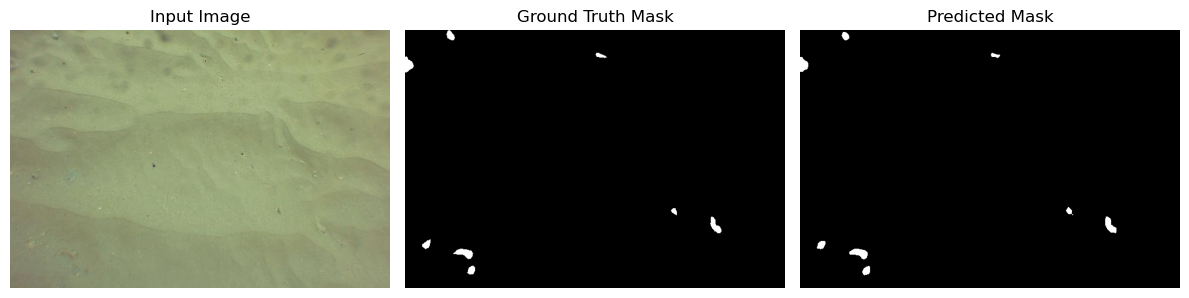

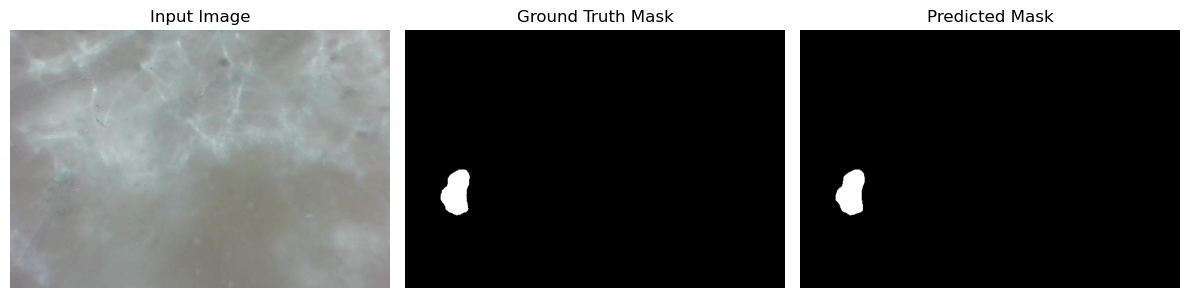

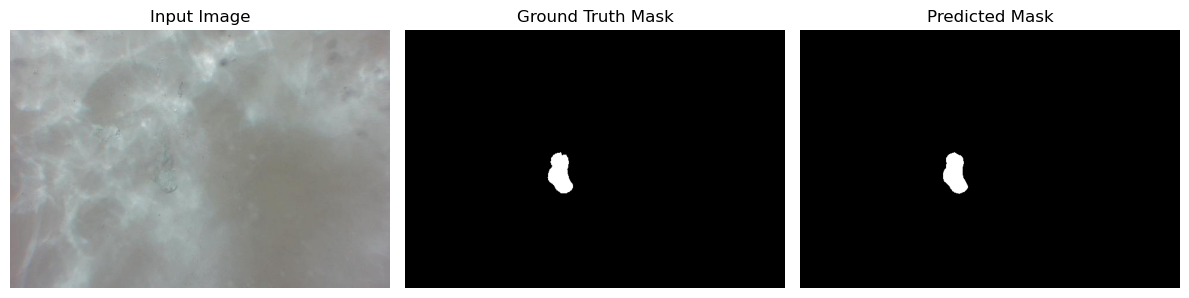

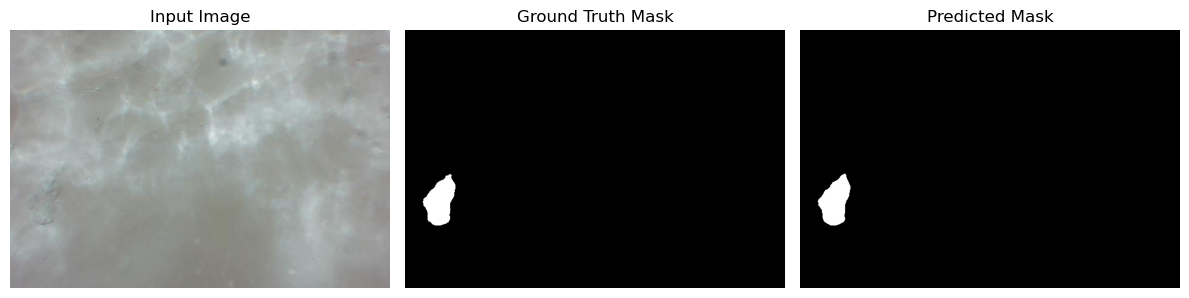

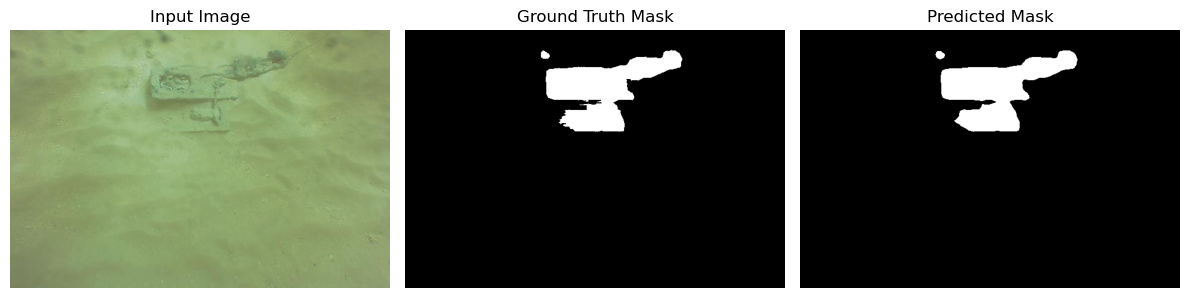

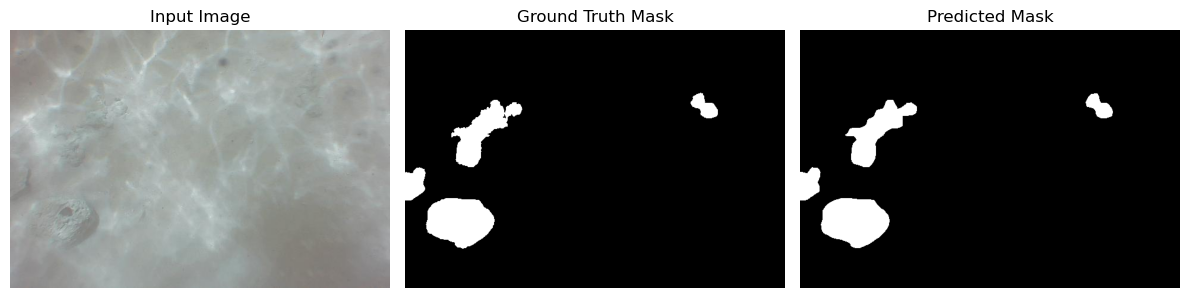

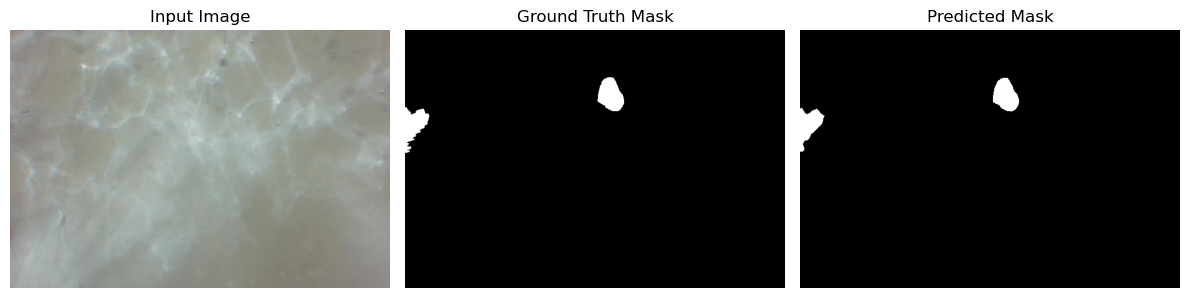

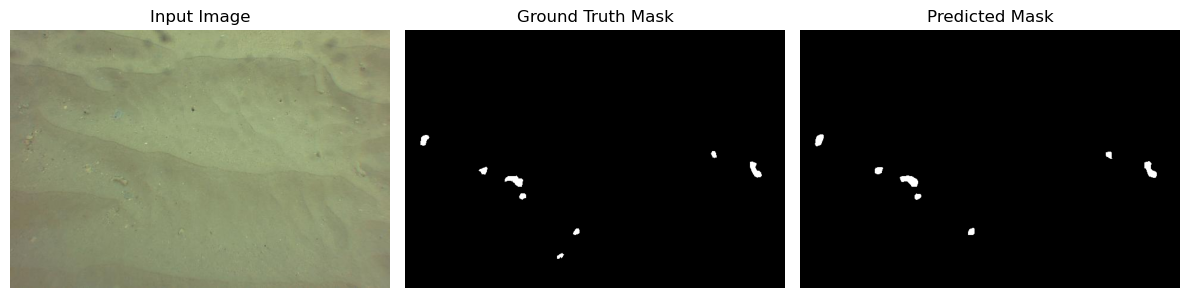

In [8]:
# Visualization of sample predictions
sample_images, sample_masks = next(iter(train_loader))
batch_size = sample_images.shape[0]

with torch.no_grad():
    sample_images_gpu = sample_images.float().to(device)
    output = model(sample_images_gpu)['out']
    predicted_masks = torch.argmax(output, dim=1).cpu()

for i in range(batch_size):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(torch.permute(sample_images[i], (1, 2, 0)))
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(sample_masks[i], cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(predicted_masks[i], cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

### Part 6: Visualize the saved metrics

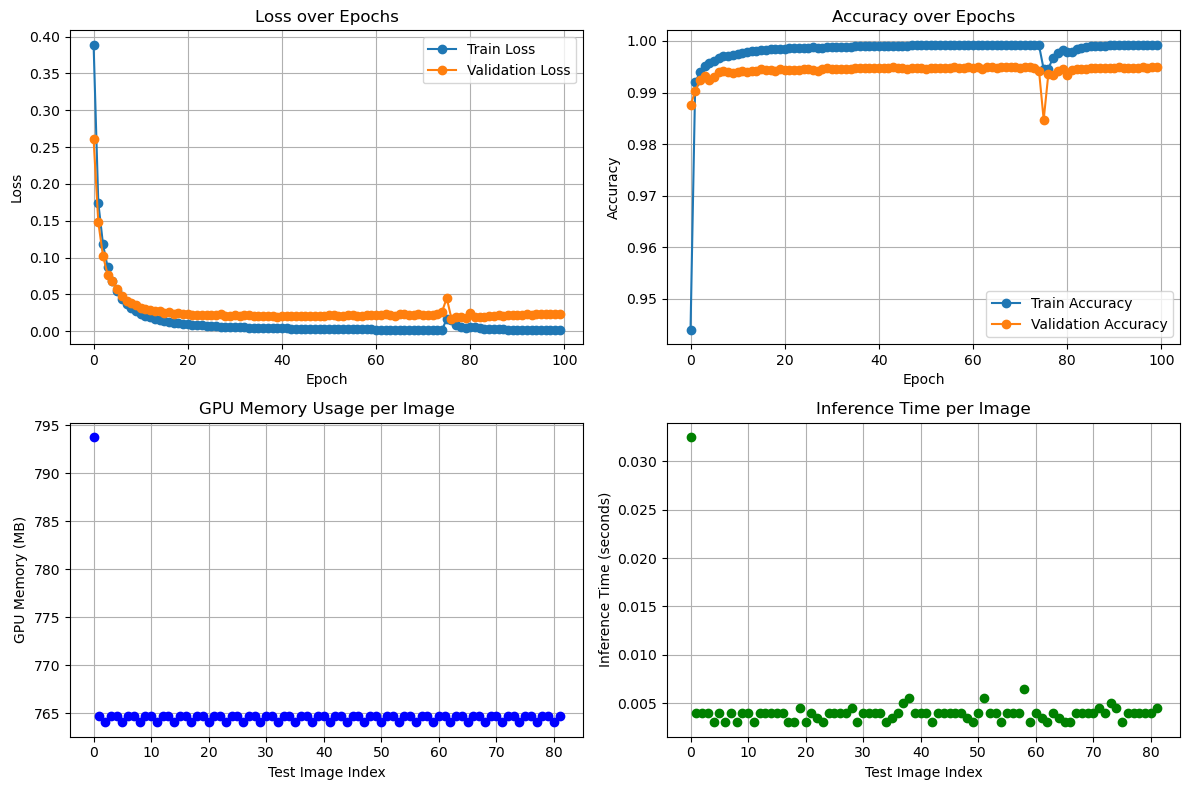

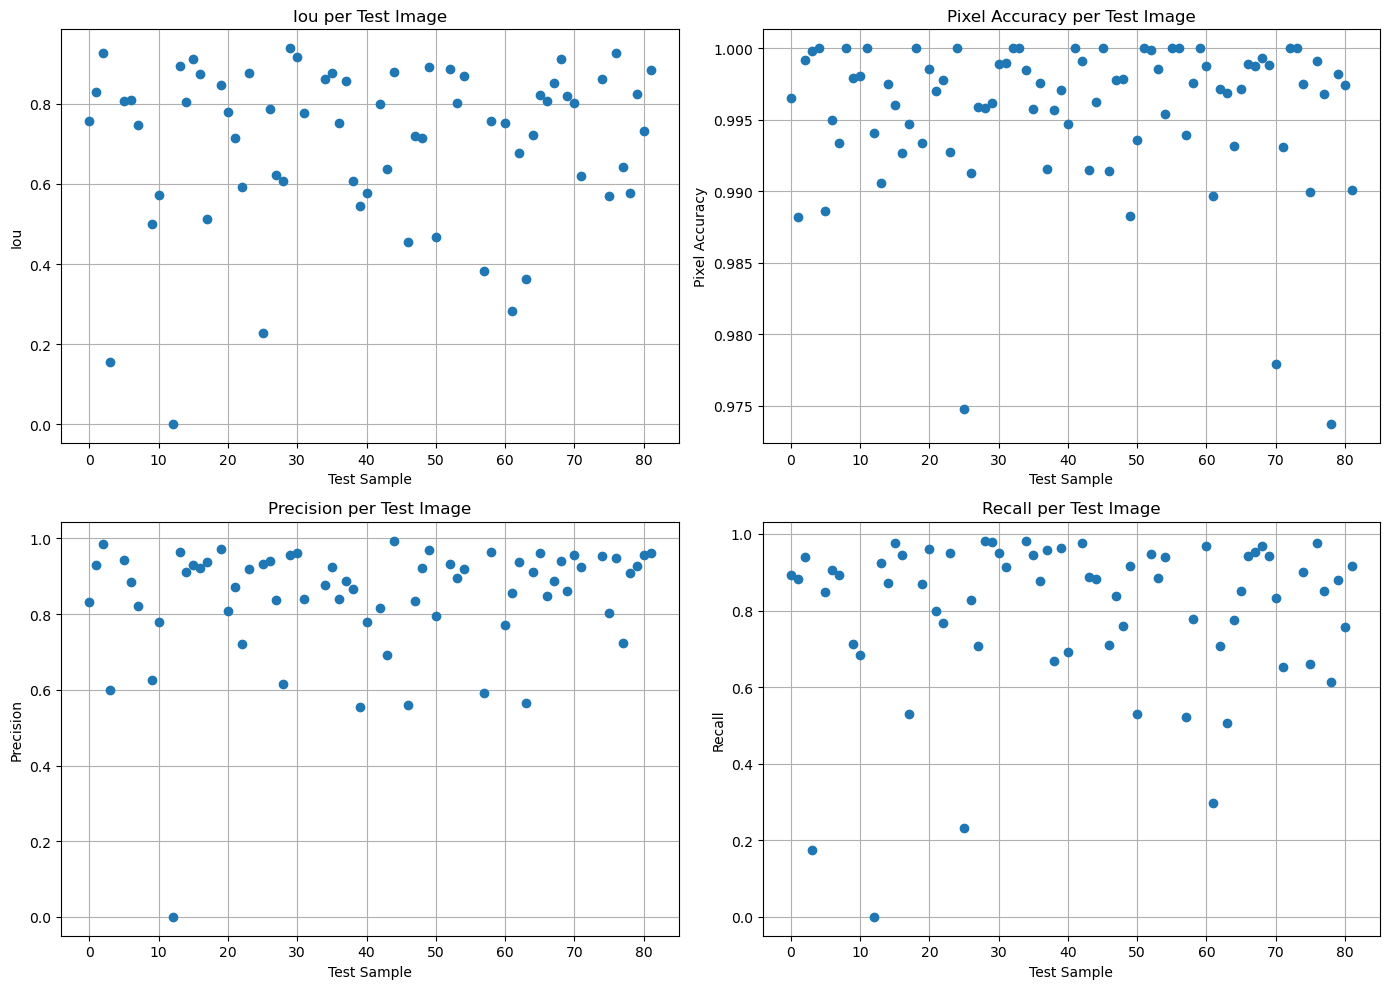

Average Test IoU: 0.7101
Average Test Pixel Accuracy: 0.9957
Average Test Precision: 0.8459
Average Test Recall: 0.8020
Average GPU Memory Usage: 764.82 MB
Average Inference Time: 0.0042 seconds
Total Model Parameter Count: 41,999,191
Model Storage Size: 160.56 MB


In [9]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load metrics from JSON file
with open("deeplabv3_finetuned_metrics.json", "r") as f:
    metrics = json.load(f)

# Plot Training and Validation Loss & Accuracy
plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(metrics["train_losses"], label='Train Loss', marker='o')
plt.plot(metrics["val_losses"], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(metrics["train_accs"], label='Train Accuracy', marker='o')
plt.plot(metrics["val_accs"], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# GPU Memory Usage per Test Image
plt.subplot(2, 2, 3)
plt.plot(metrics["gpu_memory_MB"], marker='o', color='blue', linestyle='None')
plt.title('GPU Memory Usage per Image')
plt.xlabel('Test Image Index')
plt.ylabel('GPU Memory (MB)')
plt.grid(True)

# Inference Time per Test Image
plt.subplot(2, 2, 4)
plt.plot(metrics["inference_time_per_image"], marker='o', color='green', linestyle='None')
plt.title('Inference Time per Image')
plt.xlabel('Test Image Index')
plt.ylabel('Inference Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot IoU, Pixel Accuracy, Precision, and Recall for Test Set
metric_names = ["iou", "pixel_accuracy", "precision", "recall"]
plt.figure(figsize=(14, 10))

for i, metric_name in enumerate(metric_names, 1):
    plt.subplot(2, 2, i)
    plt.plot(metrics[metric_name], marker='o', linestyle='None')
    plt.title(f'{metric_name.replace("_", " ").title()} per Test Image')
    plt.xlabel('Test Sample')
    plt.ylabel(metric_name.replace("_", " ").title())
    plt.grid(True)

plt.tight_layout()
plt.show()

# Summarize Test Metrics (using nanmean to handle NaNs gracefully)
print(f"Average Test IoU: {np.nanmean(metrics['iou']):.4f}")
print(f"Average Test Pixel Accuracy: {np.mean(metrics['pixel_accuracy']):.4f}")
print(f"Average Test Precision: {np.nanmean(metrics['precision']):.4f}")
print(f"Average Test Recall: {np.nanmean(metrics['recall']):.4f}")

# Summarize GPU and Inference Time Metrics
print(f"Average GPU Memory Usage: {np.mean(metrics['gpu_memory_MB']):.2f} MB")
print(f"Average Inference Time: {np.mean(metrics['inference_time_per_image']):.4f} seconds")

# Print Model Hardware Metrics
print(f"Total Model Parameter Count: {metrics['param_count']:,}")
print(f"Model Storage Size: {metrics['storage_size_MB']:.2f} MB")
